# Regression: California Housing

## Business Goal:
**Produce estimates of house prices so that real estate agents can use that to make pricing decisions faster and more consistently.**

In [1]:
import random

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("california_housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Data Exploration

<AxesSubplot: >

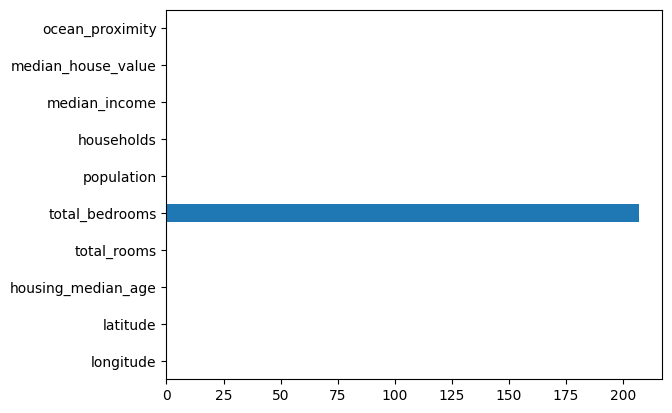

In [3]:
df.isna().sum().plot.barh()

In [4]:
df["total_bedrooms"].describe()

count    20433.000000
mean       537.870553
std        421.385070
min          1.000000
25%        296.000000
50%        435.000000
75%        647.000000
max       6445.000000
Name: total_bedrooms, dtype: float64

<AxesSubplot: >

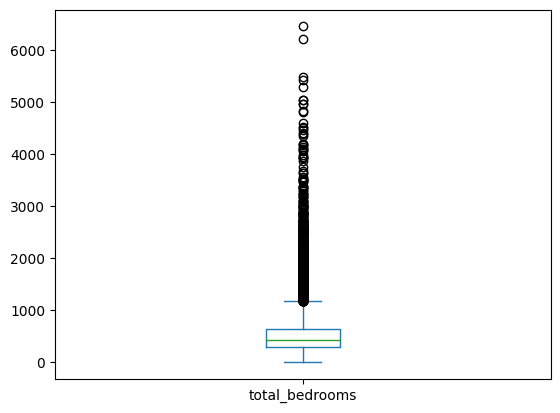

In [5]:
df["total_bedrooms"].plot.box()

### Train / Test split

In [6]:
# find out the size of the test set
df.shape[0] // 5  # 20%

4128

In [7]:
random.seed(777)  # initializes the random number generator
indices = list(range(0, df.shape[0]))
random.shuffle(indices)

training_indices = indices[:-8256]
validation_indices = indices[-8256:-4128]
test_indices = indices[-4128:]

training_indices[:10]

[6446, 1869, 13618, 6102, 19764, 16589, 5091, 4156, 14362, 10826]

In [8]:
df_train = df.iloc[training_indices].copy()  # use copies so that pandas does not spam me with warnings
df_val = df.iloc[validation_indices].copy()
df_test = df.iloc[test_indices].copy()

In [9]:
# alternative: Scikit-learn
from sklearn.model_selection import train_test_split

df_trainval, df_test2 = train_test_split(df, test_size=0.2, random_state=777)
df_train2, df_val2 = train_test_split(df_trainval, test_size=0.25)

In [10]:
df_train.shape, df_val.shape, df_test.shape  # column number must be the same!

((12384, 10), (4128, 10), (4128, 10))

In [11]:
df_train2.shape, df_val2.shape, df_test2.shape  # same numbers

((12384, 10), (4128, 10), (4128, 10))

## Feature Engineering

**ground rule in scikit: call .fit() only for training data!**

In [12]:
# idea: try label encoding and one-hot encoding on ocean_prox and see which is better

### Transform the categorical values in ocean_proximity

In [13]:
from sklearn.preprocessing import LabelEncoder

In [14]:
# creates one new column
encoder = LabelEncoder()  # initialize.. boring
encoder.fit(df_train["ocean_proximity"])        # see what unique values occur in the column (ONLY FOR train!!!)
df_train["ocean_label"] = encoder.transform(df_train["ocean_proximity"])  # translate the values to 0..n
df_val["ocean_label"] = encoder.transform(df_val["ocean_proximity"])
df_test["ocean_label"] = encoder.transform(df_test["ocean_proximity"])

#### Try one-hot encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

### Fix missing values in total_bedrooms

In [16]:
median = df_train["total_bedrooms"].median()
df_train["total_bedrooms"].fillna(median, inplace=True)
df_val["total_bedrooms"].fillna(median, inplace=True)
df_test["total_bedrooms"].fillna(median, inplace=True)

### Identify X and y

In [17]:
# separate the target variable y (dependent variable): the thing we want to predict
y_train = df_train["median_house_value"]
y_val = df_val["median_house_value"]
y_test = df_test["median_house_value"]

In [18]:
# df_train.columns

In [47]:
# separate the predictor features X (independent variables): the things we use for predicting
columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
           'ocean_proximity',
           # 'ocean_label'
          ]
X_train = df_train[columns]
X_val = df_val[columns]
X_test = df_test[columns]

### One Hot Encoding + Binning of coordinates

In [48]:
from sklearn.preprocessing import KBinsDiscretizer

In [49]:
# creates five new columns
ct = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(sparse_output=False), ["ocean_proximity"]), # use OHEnc for the ocean_proximity column
        #('binning', KBinsDiscretizer(n_bins=10), ["longitude", "latitude", "population", "total_bedrooms"]),
    ],  
    remainder='passthrough'                            # do nothing to the other columns
)
ct.fit(X_train)
X_train = ct.transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

In [50]:
X_train.shape, X_val.shape, X_test.shape

((12384, 13), (4128, 13), (4128, 13))

In [51]:
y_train.shape, y_val.shape, y_test.shape

((12384,), (4128,), (4128,))

## The Model

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [53]:
m = LinearRegression(fit_intercept=True)  # 1. initialize the model (set hyperparameters)
# m = KNeighborsRegressor(n_neighbors=5)
m.fit(X_train, y_train)                   # 2. fit the model with training data (NEVER validation or test data!)

LinearRegression()

In [54]:
y_pred = m.predict(X_train)
y_pred

array([302156.09276226,  28009.30157762, 106545.68865008, ...,
       236716.12247609, 163519.70490043, 108354.64385679])

In [55]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
)

In [56]:
mean_squared_error(y_train, y_pred)  # MSE has no unit

4713416492.241685

In [57]:
y_pred_val = m.predict(X_val)
mean_squared_error(y_val, y_pred_val)

4924307792.059996

### Cross-Validation

repeat the model training with different portions of the data as validation sets to examine the robustness of our model.

Result: 5 models with 5 scores

In [58]:
from sklearn.model_selection import cross_val_score

In [59]:
cross_val_score(
    m,            # the model
    X = X_train,
    y = y_train,
    cv = 5,       # the number of splits (validation subsets)
    # scoring=mean_squared_error, # have to look this up
)

array([0.62446536, 0.65293498, 0.65185511, 0.63588015, 0.65284402])

Result are R^2 values, not MSE at the moment. 

We want that these numbers are close to each other.

#### Why 5 portions, not 10 or 100?

* statistics: with high numbers, the valiation set becomes very small
* performance: it takes longer to train 100 models than 5

### MAE (Mean Absolute Error)

advantage: unit is the same as in the target column y

$$mae = \frac{1}{n} \sum | y_i - y_{true} |$$

In [60]:
round(mean_absolute_error(y_train, y_pred), 1)  # USD

50014.4

In [61]:
round(mean_absolute_error(y_val, y_pred_val), 1)  # USD

50247.8

## Overfitting

if your model has too much information, it will start learning the training data by heart.
Result: 
    
* good performance for training data
* bad performance for validation / test data

**ideally, your training and validation scores should be the same**

## Calculate Test Score

In [62]:
y_pred_test = m.predict(X_test)

In [63]:
mean_squared_error(y_test, y_pred_test)

4569220731.211587

In [64]:
mean_absolute_error(y_test, y_pred_test)

48996.87781980243

### Checking model parameters

In [66]:
# we want to see our slope(s) and intercept
m.coef_  # slopes

array([-3.45467971e+04, -7.70624637e+04,  1.85963349e+05, -4.35392829e+04,
       -3.08148054e+04, -2.54988853e+04, -2.38627961e+04,  1.16816710e+03,
       -4.96010066e+00,  6.98615944e+01, -3.73382578e+01,  7.81128743e+01,
        3.91210655e+04])

In [67]:
m.intercept_

-2138458.5866370546

In [71]:
labels = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population', 'households', 'median_income',
]           
len(labels)

8

<AxesSubplot: >

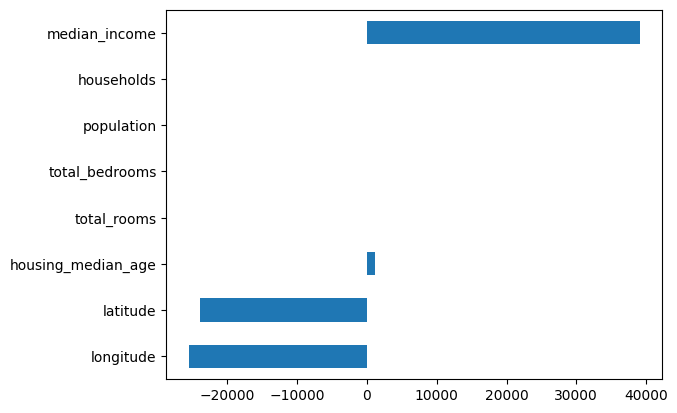

In [74]:
# first 5 columns are for ocean_proximity, ignore
slopes = pd.Series(m.coef_[5:], index=labels)
slopes.plot.barh()

In [76]:
slopes

longitude            -25498.885289
latitude             -23862.796069
housing_median_age     1168.167103
total_rooms              -4.960101
total_bedrooms           69.861594
population              -37.338258
households               78.112874
median_income         39121.065451
dtype: float64

* median income has a positive impact on y (the house price)
* one unit of median income (1-10) means +40000 USD on the price
* one unit of latitude (1 degree to north) means -22000 USD cheaper

In [75]:
df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY


### Inspect Residuals

MSE and MAE are *averages*. I want to know how my errors are actually distributed.

In [78]:
# residuals: error per data point
residuals = y_val - y_pred_val
residuals.values

array([-56261.40149077, 177781.87964984, 141322.10795511, ...,
        41499.90297853,   7340.92040699,   8910.85153647])

In [80]:
import seaborn as sns

<AxesSubplot: xlabel='median_house_value', ylabel='Count'>

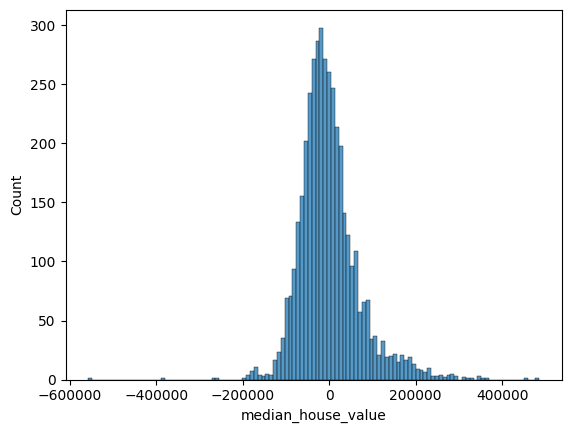

In [81]:
sns.histplot(data=residuals)

ideally, residuals are normally distributed (bell-shaped curve) with a mean around zero

### Assumptions: checking residuals in more detail

**Gauss-Markov Theorem:**

1. mean of the residuals is zero

In [84]:
residuals.mean()  # assumption #1 is met

128.30669712049902

2. residuals are independent of X

ideally, the residuals are random. They should not be correlated with our data

3. variance of the residuals is independent of X

**if you can verify all three assumptions, then the mean squared error is guaranteed to give you the best model in Gradient Descent.**

In [89]:
df_val['residual'] = residuals

<AxesSubplot: >

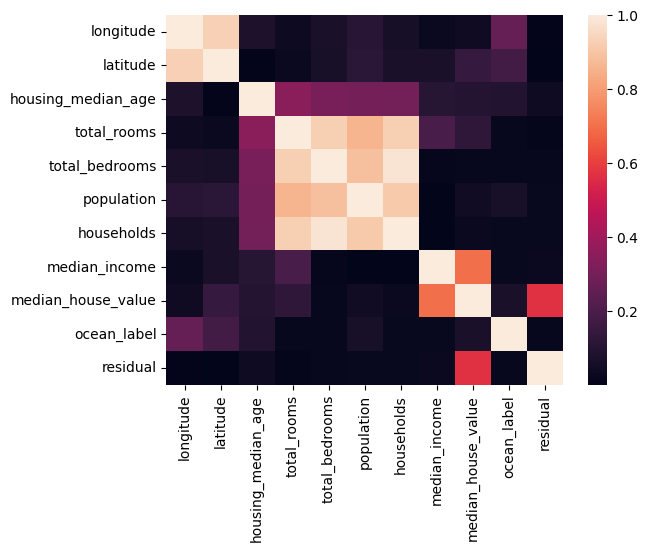

In [94]:
sns.heatmap(df_val.corr(numeric_only=True).abs())